In [1]:
import mne
#from mne_bids import (BIDSPath, read_raw_bids, print_dir_tree, make_report,
#                      find_matching_paths, get_entity_vals)
import numpy as np
import matplotlib.pyplot as plt
# import scipy as sp
# from scipy import signal
# import seaborn as sns
import pandas as pd
from pathlib import Path
import os
from time import time
from autoreject import AutoReject, Ransac, get_rejection_threshold

%matplotlib qt

In [2]:
# Initialize an empty dictionary for subject grouping
subject_groups = {}

# Add subjects to the dictionary based on their group
for i in range(1, 25):
    subject_groups[f"sub-{i:03d}"] = "htr" #Himalayan

for i in range(25, 56):
    subject_groups[f"sub-{i:03d}"] = "ctr" #Control

for i in range(56, 60):
    subject_groups[f"sub-{i:03d}"] = "tm" #Transcendental???

for i in range(60, 79):
    subject_groups[f"sub-{i:03d}"] = "vip" #Vipassana

for i in range(79, 99):
    subject_groups[f"sub-{i:03d}"] = "sny" #Shoonya Yoga


# Creating event id for each task and practice
event_id = {'htr/med1':1, 'htr/med2':2, 'htr/think1':3, 'htr/think2':4,
          'ctr/med1':5, 'ctr/med2':6, 'ctr/think1':7, 'ctr/think2':8,
          'tm/med1': 9, 'tm/med2' :10, 'tm/think1':11, 'tm/think2':12,
          'vip/med1':13, 'vip/med2':14, 'vip/think1':15, 'vip/think2':16,
          'sny/med1':17, 'sny/med2':18, 'sny/think1':19, 'sny/think2':20}




def load_task_data(bids_root, subject_id, tasks):
    """
    Load specific task EEG data for a subject from a BIDS-like dataset.
    
    Parameters:
    - bids_root: str, path to the root of the dataset.
    - subject_id: str, subject identifier (e.g., '088').
    - tasks: list of str, the task names to load (e.g., ['med2', 'think2']).
    
    Returns:
    - raw_dict: dict, containing MNE Raw objects for each task.
    """
    # Define the subject's EEG folder
    subject_path = os.path.join(bids_root, f"sub-{subject_id}", "eeg")
    
    if not os.path.exists(subject_path):
        raise FileNotFoundError(f"Subject folder not found: {subject_path}")
    
    raw_dict = {}  # Dictionary to hold Raw objects for each task
    
    for task in tasks:
        # Locate the BDF file for the specific task
        bdf_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_eeg.bdf")
        if not os.path.exists(bdf_file):
            print(f"WARNING: BDF file not found for task '{task}'. Skipping...")
            continue
        
        # Load the BDF file
        raw = mne.io.read_raw_bdf(bdf_file, preload=True)
        print(f"Loaded BDF file for task '{task}': {bdf_file}")
        
        # Optionally, load metadata from JSON/TSV files
        # Metadata file paths
        json_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_eeg.json")
        tsv_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_channels.tsv")
        
        metadata = {}
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                metadata['json'] = f.read()
            print(f"Loaded metadata JSON for task '{task}'")
        
        if os.path.exists(tsv_file):
            metadata['tsv'] = tsv_file  # Store TSV file path for later use if needed
            print(f"Loaded metadata TSV for task '{task}'")
        
        # Add the loaded data and metadata to the dictionary
        raw_dict[task] = {
            'raw': raw,
            'metadata': metadata
        }
    
    if not raw_dict:
        raise ValueError(f"No data was loaded for subject {subject_id} with tasks {tasks}.")
    
    return raw_dict


In [3]:
# Print out intiation text with path to the dataset and events
print("\n##### Initiating the preprocessing pipeline for the Braboszcz et al. (2017) dataset. ######")

bids_root = "/home/sivert/Documents/Specialization_project/Datasets/ds003969/"
subject_id = "077"
tasks = ["med2", "think2"]
subject_group = subject_groups['sub-'+subject_id]

print('\n##### Loading data #####')
# Load data
subject_data = load_task_data(bids_root, subject_id, tasks)

# Access raw data for a specific task
raw_med = subject_data['med2']['raw']
raw_med.set_channel_types({'EXG1': 'misc',
                    'EXG2': 'misc',
                    'EXG3': 'misc',
                    'EXG4': 'misc',
                    'EXG5': 'misc',
                    'EXG6': 'misc',
                    'EXG7': 'misc',
                    'EXG8': 'misc',
                    'GSR1': 'misc',
                    'GSR2': 'misc',
                    'Erg1': 'misc',
                    'Erg2': 'misc',
                    'Resp': 'bio',
                    'Plet': 'bio',
                    'Temp': 'bio'
})
# Drop non-eeg channels
#raw_med.pick('eeg')

raw_med.plot(highpass=1, lowpass=None, block=True)


from mne.channels import find_ch_adjacency
from mne.viz import plot_ch_adjacency




##### Initiating the preprocessing pipeline for the Braboszcz et al. (2017) dataset. ######

##### Loading data #####


FileNotFoundError: Subject folder not found: /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-077\eeg

No bad channels found for sub-003 - task-med2
Extracting EDF parameters from /home/sivert/Documents/Master_AttentionalDirectionResearch/data/braboszcz2017/raw/sub-003/eeg/sub-003_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617471  =      0.000 ...   602.999 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)


/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/preprocessing_tools.py:65: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types(existing_types)


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Channels marked as bad:
none


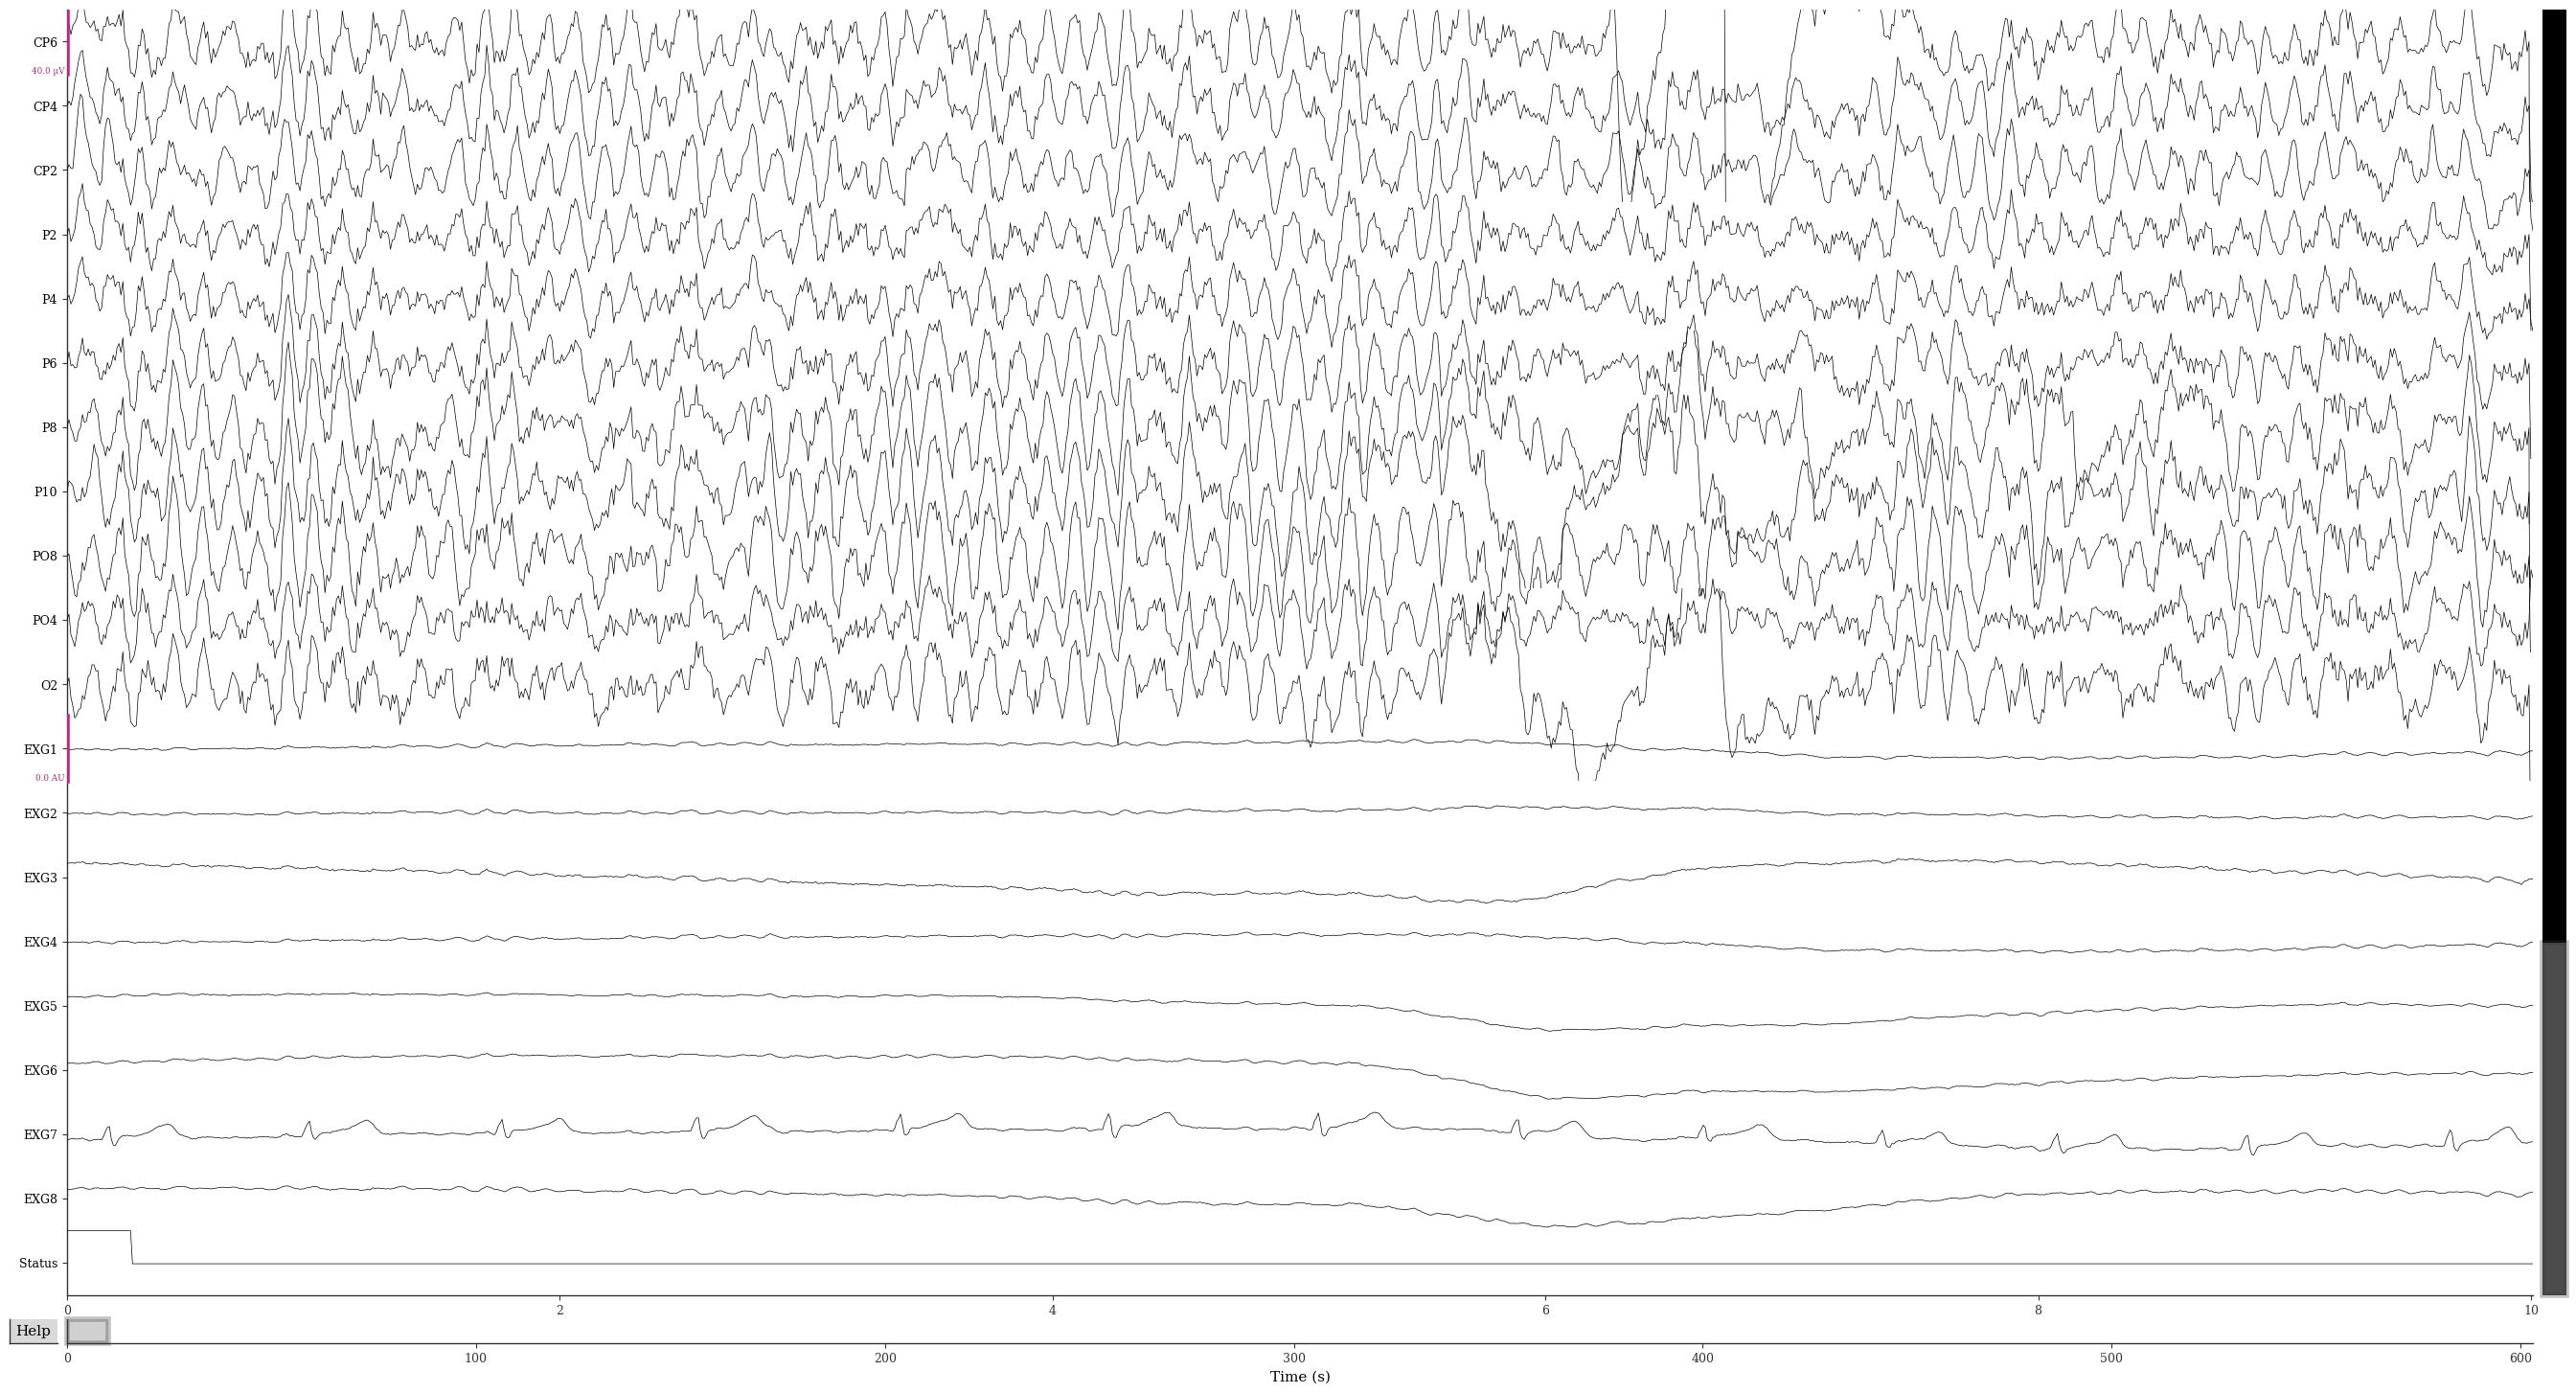

In [3]:
from utils.file_io import load_raw_data, load_bad_channels
from utils.preprocessing_tools import prepare_raw_data
from utils.config import DATASETS, set_plot_style, EEG_SETTINGS
import utils.config as config

%matplotlib qt

set_plot_style()

DATASET = DATASETS['braboszcz2017']
path_derivatives = DATASET.path_derivatives
subject = '003'
task = 'med2'

bad_chs = load_bad_channels(
        save_dir=path_derivatives,
        dataset=DATASET.f_name,
        subject=subject,
        task=task
    )

raw = load_raw_data(dataset=DATASET, subject=subject, task=task)

raw = prepare_raw_data(raw, dataset=DATASET, eeg_settings=config.EEG_SETTINGS)

#raw.info['bads'] = bad_chs

raw.plot(highpass=1, lowpass=None, block=True)


Found existing bad channels for sub-6 - ses-2
Extracting EDF parameters from /home/sivert/Documents/Master_AttentionalDirectionResearch/data/jin2019/raw/sub6_2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  5719.998 secs...


/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/preprocessing_tools.py:96: RuntimeWarning: The unit for channel(s) EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
826 events found on stim channel Status
Event IDs: [   10    11    12    13    14    20    21 65790]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
825 events found on stim channel Status
Event IDs: [10 11 12 13 14 20 21]
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB



/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/preprocessing_tools.py:115: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(eeg_settings["SAMPLING_RATE"])


Channels marked as bad:
none


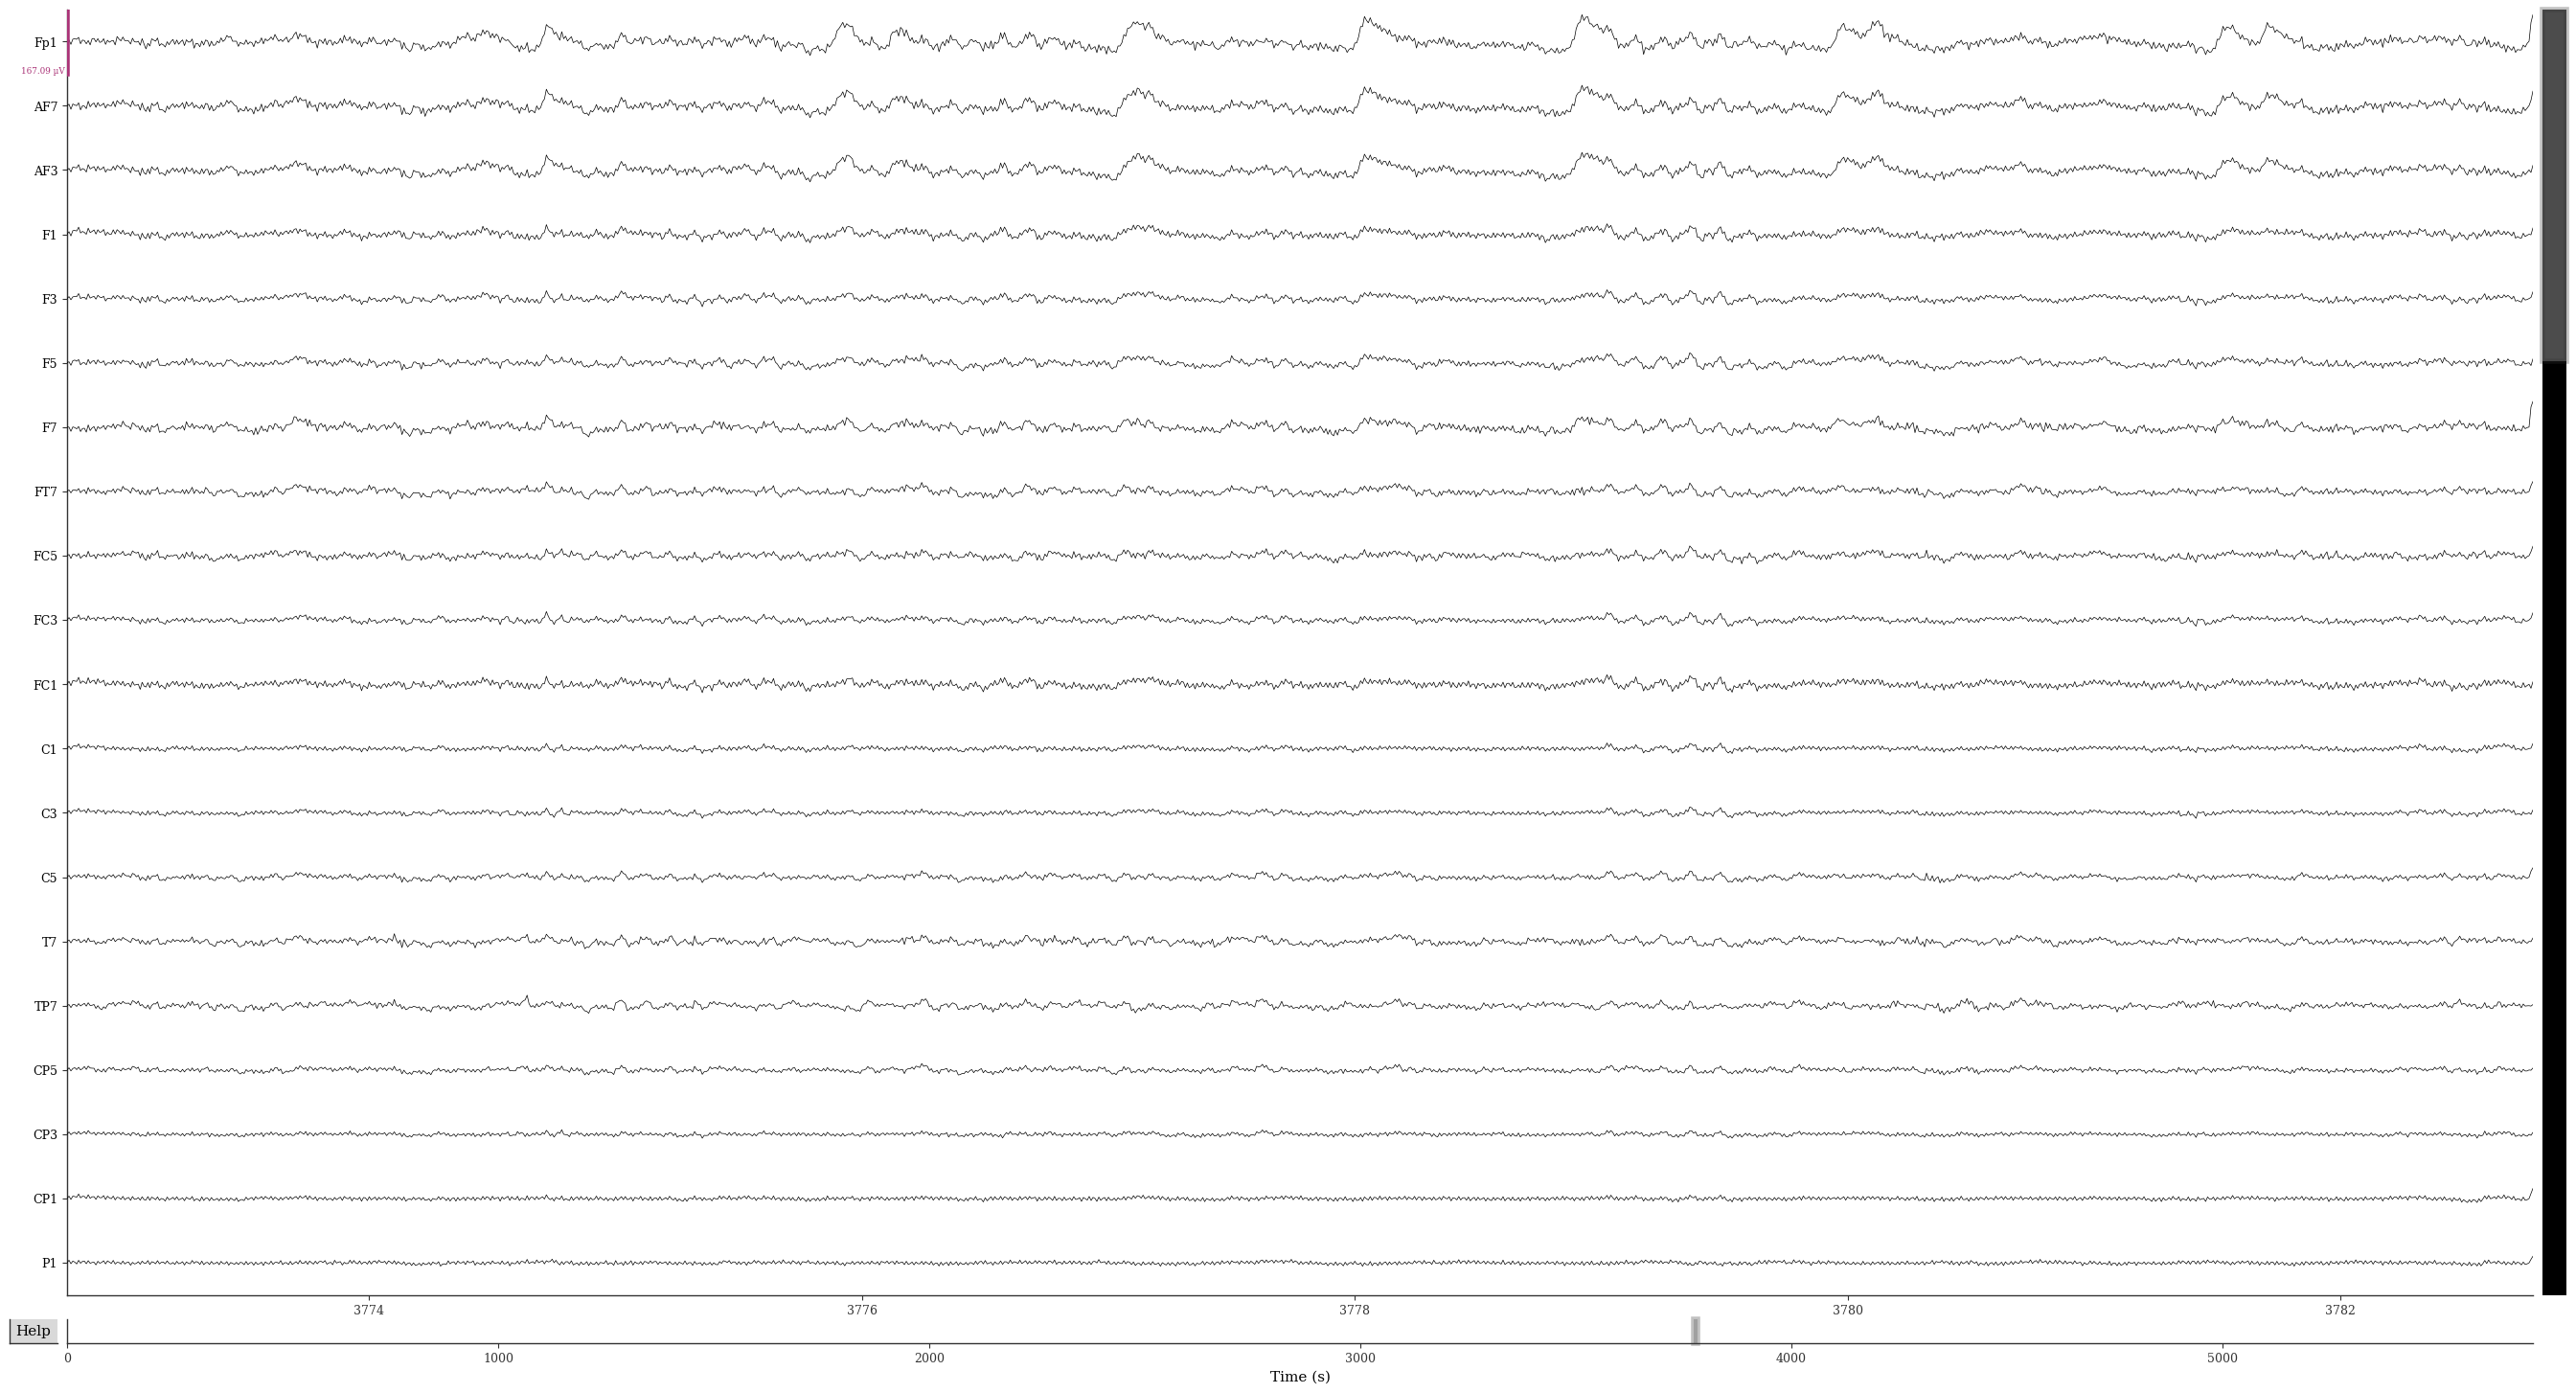

In [6]:
from utils.file_io import load_raw_data, load_bad_channels
from utils.preprocessing_tools import prepare_raw_data
from utils.config import DATASETS
import utils.config as config

DATASET = DATASETS['jin2019']
path_derivatives = DATASET.path_derivatives
subject = 6
session = 2

bad_chs = load_bad_channels(
        save_dir=path_derivatives,
        dataset=DATASET.f_name,
        subject=subject,
        session=session
    )

raw = load_raw_data(dataset=DATASET, subject=subject, session=session)

raw = prepare_raw_data(raw, dataset=DATASET, eeg_settings=config.EEG_SETTINGS)

raw.info['bads'] = bad_chs

raw.plot(highpass=1, lowpass=None, block=True)


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""
/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:48: RuntimeWarning: Unknown types found, setting as type EEG:
other: ['ANG', 'LN', 'SD', 'SP']
  return mne.io.read_raw_eeglab(path, preload=preload)


['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST', 'LN', 'ANG', 'SP', 'SD']
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/file_io.py:48: RuntimeWarning: Not setting positions of 6 eog/misc channels found in montage:
['LHEOG', 'RHEOG', 'UVEOG', 'LVEOG', 'LMAST', 'RMAST']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  return mne.io.read_raw_eeglab(path, preload=preload)
/home/sivert/Documents/Master_AttentionalDirectionResearch/utils/preprocessing_tools.py:117: RuntimeWarning: The unit for channel(s) ANG, LN, SD, SP has changed from V to NA.
  raw.set_channel_types({


Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Using matplotlib as 2D backend.
Channels marked as bad:
none


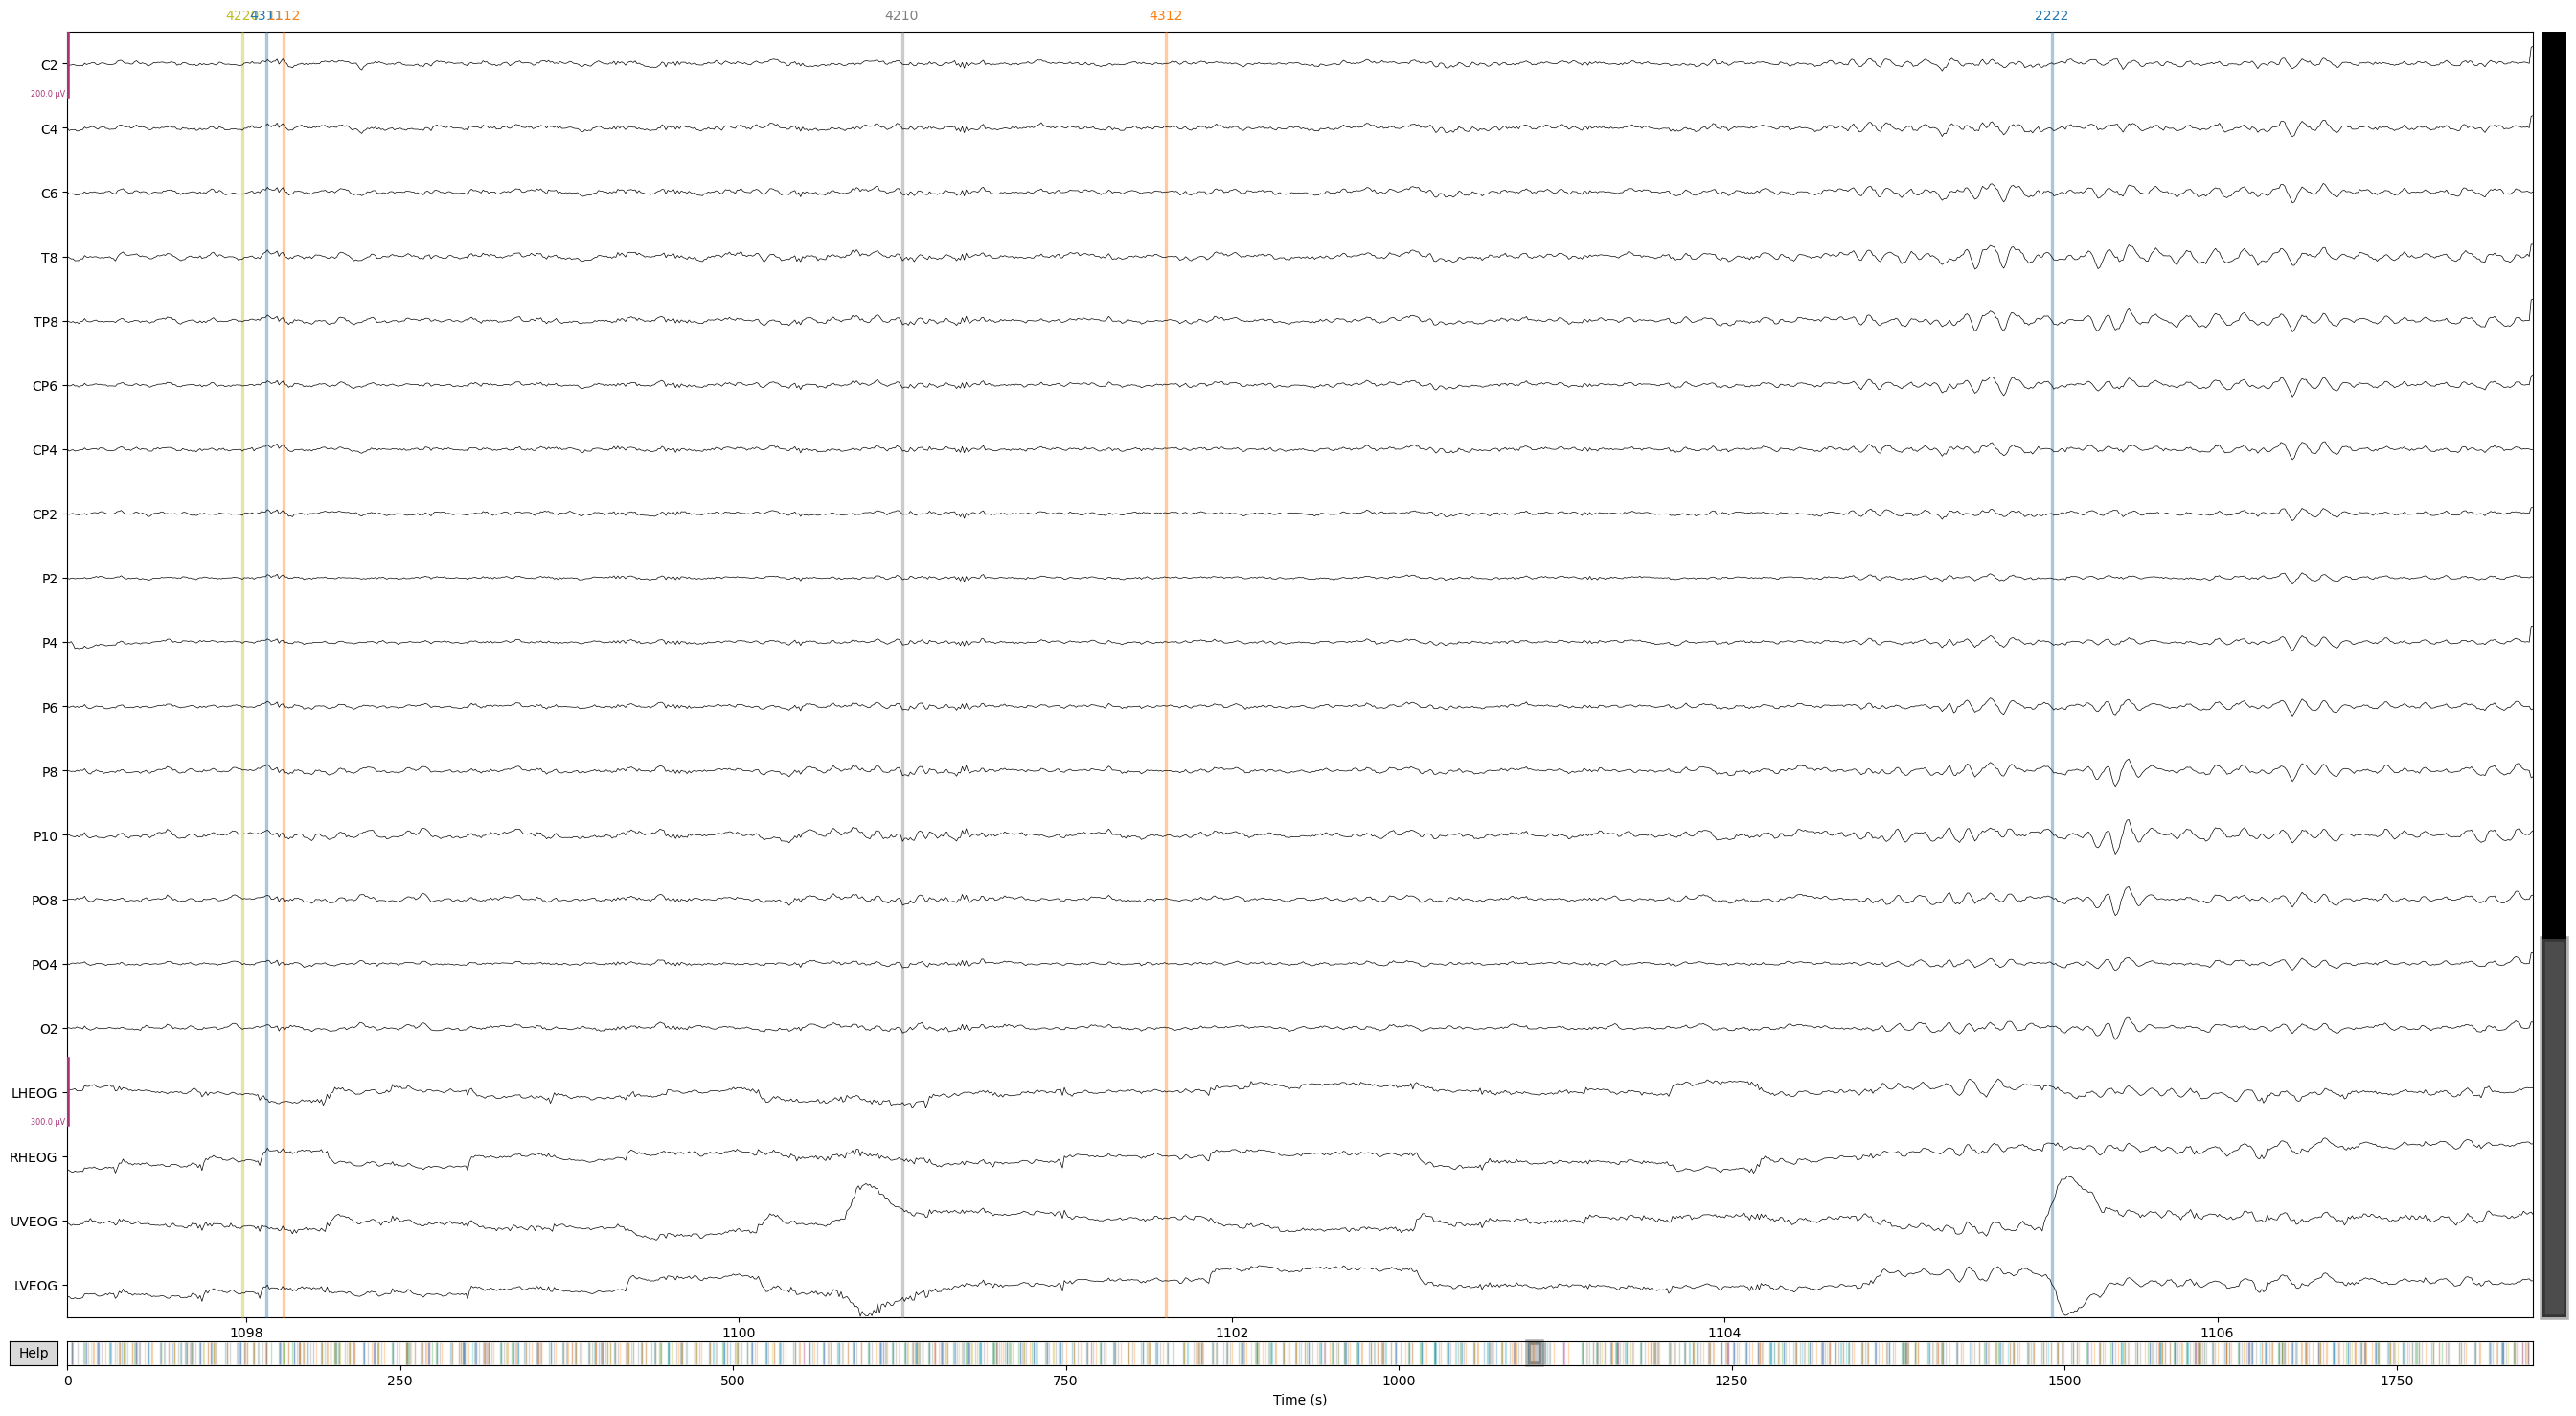

In [1]:
from utils.file_io import load_raw_data, load_bad_channels
from utils.preprocessing_tools import prepare_raw_data
from utils.config import DATASETS
import utils.config as config

%matplotlib qt

DATASET = DATASETS['touryan2022']
path_derivatives = DATASET.path_derivatives
subject = 1
run = 2

# bad_chs = load_bad_channels(
#         save_dir=path_derivatives,
#         dataset=DATASET.f_name,
#         subject=subject,
#         run=run
#     )

raw = load_raw_data(dataset=DATASET, subject=subject, run=run)

print(raw.info['ch_names'])

raw = prepare_raw_data(raw, dataset=DATASET, eeg_settings=config.EEG_SETTINGS)

#raw.info['bads'] = bad_chs

raw.plot(highpass=1, scalings=dict(eeg=100e-6), lowpass=None, block=True)